In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Reading data

In [2]:
issues = pd.read_csv('issues.csv')
commits = pd.read_csv('commits.csv')

In [3]:
data = pd.merge(commits, issues, on = 'key', how = 'inner')

In [4]:
df = data[['author_name', 'author_email', 'committer_name', 'committer_email', 'time', 
                                       'time_offset', 'message_encoding','severity']]

# Transforming timestamps to normal date and getting day, year, month

In [5]:
df['normal_date'] = pd.to_datetime(df.time.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df = df.sort_values('normal_date')

In [7]:
df['day'] = df.normal_date.map(lambda x: x.day)
df['month'] = df.normal_date.map(lambda x: x.month)
df['year'] = df.normal_date.map(lambda x: x.year)

# Counting number of commits by author per day and making plot using log1p function

In [8]:
author_dict = {}
for i in df.author_name.unique():
    author_df = df[df.author_name == i]
    if len(author_df) > 1:
        author_dict[i] = (author_df.normal_date.max() - author_df.normal_date.min()).days/len(author_df)
author_data = pd.DataFrame(author_dict, index = [0]).T
author_data = author_data[author_data[0] != 0].sort_values(0)

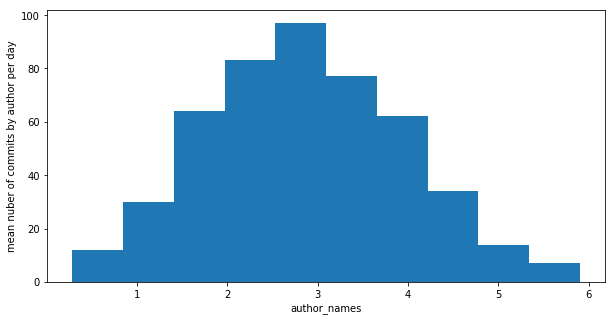

In [9]:
plt.figure(figsize = (10,5))
plt.hist(np.log1p(author_data.values))
plt.ylabel('mean nuber of commits by author per day')
plt.xlabel('author_names')
plt.show()

#  Counting number of commits by commiter per day and making plot using log1p function

In [10]:
committer_dict = {}
for i in df.committer_name.unique():
    committer_df = df[df.committer_name == i]
    if len(committer_df) > 1:
        committer_dict[i] = (committer_df.normal_date.max() - committer_df.normal_date.min()).days/len(committer_df)
committer_data = pd.DataFrame(committer_dict, index = [0]).T
committer_data = committer_data[committer_data[0] != 0].sort_values(0)

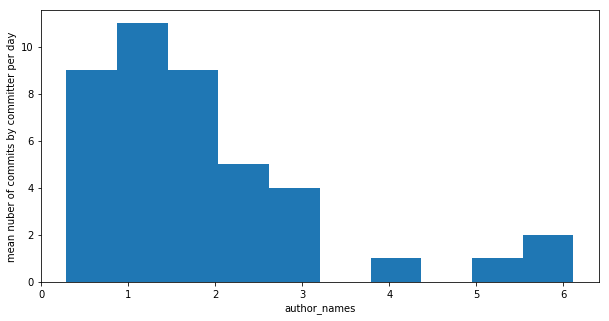

In [11]:
plt.figure(figsize = (10,5))
plt.hist(np.log1p(committer_data.values))
plt.ylabel('mean nuber of commits by committer per day')
plt.xlabel('author_names')
plt.show()

# Ploting number of commits per month

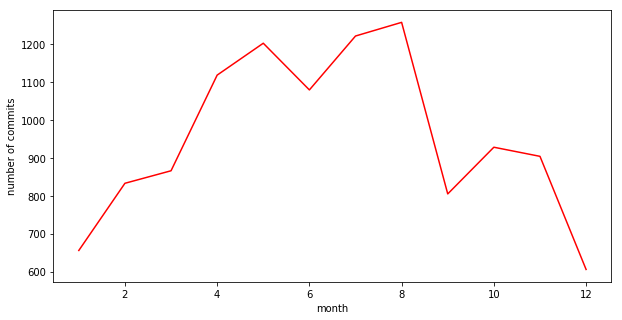

In [12]:
plt.figure(figsize = (10,5))
plt.plot(df.groupby('month').count().author_name, 'r')
plt.xlabel('month')
plt.ylabel('number of commits')
plt.show()

# Ploting number of commits per year 

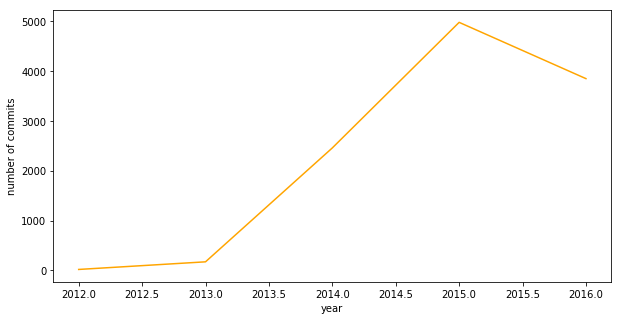

In [13]:
plt.figure(figsize = (10,5))
plt.plot(df.groupby('year').count().author_name, 'orange')
plt.xlabel('year')
plt.ylabel('number of commits')
plt.show()

# Ploting target destribution

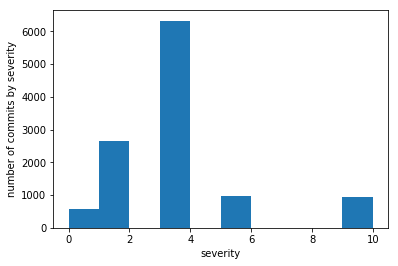

In [14]:
plt.hist(df.severity.map(int))
plt.ylabel('number of commits by severity')
plt.xlabel('severity')
plt.show()

In [15]:
df.author_name.unique().shape

(1046,)

So we need to predict severity of an Issue. We an information: who sends this issue and hs mail, who commits this issue and his mail, time when the issue was commited, time variation and text of commit. We could observe that number of unique emails of committers is greater than the number of unique names of committers. So several committers have common email. We could observe that number of commits per month could very a lot. Also if we will look at first plot (number of commits by author per day using log1p func) it has normal deviation. Also target classes strongly unbalanced.

# Getting tags from message encoding

In [16]:
df['new_enc'] = df.message_encoding.map(lambda x: x if ('[' in x) & (']' in x) else 0)

In [17]:
df.loc[df.new_enc != 0, 'new_enc'] = df.loc[df.new_enc != 0, 'new_enc'].map(lambda x: x.split())

In [18]:
df.loc[df.new_enc != 0, 'new_enc'] = df.loc[df.new_enc != 0, 'new_enc'].map(lambda x: x[0].lower())

In [19]:
df.loc[df.new_enc != 0, 'new_enc'] = df.loc[df.new_enc != 0, 'new_enc'].map(lambda x: x if ('[' in x) & (']' in x) else 0)

In [20]:
df.loc[df.new_enc != 0, 'new_enc'] = df.loc[df.new_enc != 0, 'new_enc'].map(lambda x: x.split('[')[-1].replace(']','') if len(x) > 1 else 0)

In [21]:
df.loc[df.new_enc != 0, 'new_enc'] = df.loc[df.new_enc != 0, 'new_enc'].map(lambda x: x if 'spark' not in x else 0)

In [22]:
df.new_enc = df.new_enc.map(lambda x: 'no label' if x == 0 else x)

In [23]:
follow = ['follow', 'followup', 'follw-up' ]

In [24]:
df.loc[df.new_enc == follow[0], 'new_enc'] = df.loc[df.new_enc == follow[0], 'new_enc'].map(lambda x: x.replace(follow[0], 'follow-up'))
df.loc[df.new_enc == follow[1], 'new_enc'] = df.loc[df.new_enc == follow[1], 'new_enc'].map(lambda x: x.replace(follow[1], 'follow-up'))
df.loc[df.new_enc == follow[2], 'new_enc'] = df.loc[df.new_enc == follow[2], 'new_enc'].map(lambda x: x.replace(follow[2], 'follow-up'))

# Encoding Tags, severity and others

In [25]:
message_encoder = LabelEncoder()
df.new_enc = message_encoder.fit_transform(df.new_enc)

In [26]:
severity_encoder = LabelEncoder()
df.severity = severity_encoder.fit_transform(df.severity)

In [27]:
committer_email_encoder = LabelEncoder()
df['committer_email_encoder'] = committer_email_encoder.fit_transform(df.committer_email)

In [28]:
committer_name_encoder = LabelEncoder()
df['committer_name_encoder'] = committer_name_encoder.fit_transform(df.committer_name)

In [29]:
author_name_encoder = LabelEncoder()
df['author_name_encoder'] = author_name_encoder.fit_transform(df.author_name)

In [30]:
author_email_encoder = LabelEncoder()
df['author_email_encoder'] = author_email_encoder.fit_transform(df.author_email)

# Counting quantile, max, min for every author 

In [31]:
for i in df.author_name.unique():
    df.loc[df.author_name == i, 'quant_auth'] = df[df.author_name == i].time_offset.quantile()

for i in df.author_name.unique():
    df.loc[df.author_name == i, 'max_auth'] = df[df.author_name == i].time_offset.max()

for i in df.author_name.unique():
    df.loc[df.author_name == i, 'min_auth'] = df[df.author_name == i].time_offset.min()


# Counting quantile, max, min for every committer

In [32]:
for i in df.committer_name.unique():
    df.loc[df.committer_name == i, 'quant_comm'] = df.loc[df.committer_name == i, 'time_offset'].quantile()

for i in df.committer_name.unique():
    df.loc[df.committer_name == i, 'max_comm'] = df[df.committer_name == i].time_offset.max()

for i in df.committer_name.unique():
    df.loc[df.committer_name == i, 'min_comm'] = df[df.committer_name == i].time_offset.min()


# Getting hour, when the commit was done

In [33]:
df['hour'] = df.normal_date.map(lambda x: x.hour)

In [34]:
df['part_of_day'] = df.hour.map(lambda x: 0 if (x > 9) & (x <= 14) else 1 if (x > 14) & (x <= 19) else 2)

In [35]:
tdf = TfidfVectorizer(stop_words='english', min_df = 200)
tdf_d = tdf.fit_transform(df.message_encoding)

In [36]:
tdf_data = pd.DataFrame(tdf_d.todense())

In [37]:
df = df.reset_index().drop('index',1)
df = pd.merge(df.reset_index(), tdf_data.reset_index(), on = 'index')

In [38]:
df = df.drop('index',1)

# Train test split 

In [56]:
X = df.drop(['author_name', 'author_email', 'committer_name','committer_email', 'time', 'message_encoding', 'normal_date'], 1)
Y = df[['severity']]
X_train, X_test, Y_train, Y_test = train_test_split(X, X['severity'], test_size = .3, random_state = 100)

In [57]:
X_train.shape, Y_train.shape

((8032, 439), (8032,))

In [58]:
X_train = shuffle(X_train.append(X_train[X_train.severity == 0]))
X_train = shuffle(X_train.append(X_train[X_train.severity == 0]))
X_train = shuffle(X_train.append(X_train[X_train.severity == 0]))
X_train = shuffle(X_train.append(X_train[X_train.severity == 4]))
X_train = shuffle(X_train.append(X_train[X_train.severity == 4]))
X_train = shuffle(X_train.append(X_train[X_train.severity == 3]))
X_train = shuffle(X_train.append(X_train[X_train.severity == 3]))

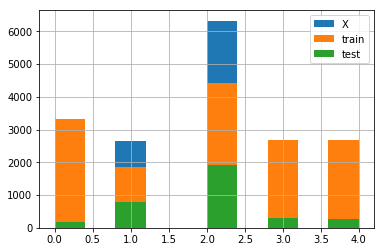

In [59]:
X.severity.hist()
X_train.severity.hist()
X_test.severity.hist()
plt.legend(['X', 'train', 'test'])
plt.show()

In [41]:
svc = SVC(class_weight = {0:3, 1:2 , 2:1, 3:2, 4:2})
svc.fit(X_train.drop('severity',1), Y_train)
print("ACC: {} , F1: {}".format(svc.score(X_test.drop('severity',1), Y_test), f1_score(svc.predict(X_test.drop('severity',1)), Y_test, average = 'weighted')))

ACC: 0.5315132152192855 , F1: 0.5642918188695487


In [42]:
gbc = GradientBoostingClassifier(max_depth = 3)
gbc.fit(X_train.drop('severity',1), X_train['severity'])
print("ACC: {} , F1: {}".format(gbc.score(X_test.drop('severity',1), Y_test), f1_score(gbc.predict(X_test.drop('severity',1)), Y_test, average = 'weighted')) )

ACC: 0.5878594249201278 , F1: 0.6656187078348172


In [48]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train.drop('severity',1), X_train['severity'])
print("ACC: {} , F1: {}".format(dtc.score(X_test.drop('severity',1), Y_test), f1_score(dtc.predict(X_test.drop('severity',1)), Y_test, average = 'weighted')) )

ACC: 0.4934650014522219 , F1: 0.5000788432589278


In [66]:
rfc = RandomForestClassifier()
rfc.fit(X_train.drop('severity',1), X_train['severity'])
print("ACC: {} , F1: {}".format(rfc.score(X_test.drop('severity',1), Y_test), f1_score(rfc.predict(X_test.drop('severity',1)), Y_test, average = 'weighted')) )

ACC: 0.5376125471972117 , F1: 0.5648059385718543


# Grid Search for our model 

In [50]:
depth = [ 2,3,4,5,6]
min_samples = [ 2, 3, 4,5]
est = [10,50,100,200,500]
param_grid = {'max_depth': depth, 'min_samples_split' : min_samples, 'n_estimators': est}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring = 'accuracy')

In [51]:
grid_search.fit(X.drop('severity',1), X['severity'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5], 'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [52]:
grid_search.best_params_

{'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 10}

# Confusion matrix

[[  43   43   74    3    0]
 [  84  239  436   22   19]
 [  50  223 1490   71   71]
 [   9   34  188   36   34]
 [   3   23  154   24   70]]


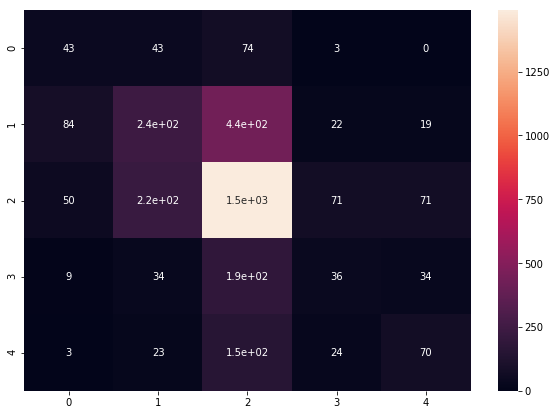

In [61]:
cm = confusion_matrix(Y_test, rfc.predict(X_test.drop('severity',1)))
print(cm)
df_cm = pd.DataFrame(cm, index = range(5), columns = range(5))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

RandomForest shows the best result over all classes. Other model could better predict the largest class but over all classes the result is worth, GradientBoosting, for example.

# Second model 

First I want to predict the biggest class 2(binary classification 2 or not 2) than for not 2 I'll predict other classes except 2. This model was build on data without using TFidVectorizer

In [87]:
df['new_class'] = df.severity.map(lambda x: 1 if x == 2 else 0)

In [88]:
X = df.drop(['author_name', 'author_email', 'committer_name','committer_email', 'time', 'message_encoding', 'severity', 'normal_date'], 1)
Y = df[['severity', 'new_class']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 100)

In [89]:
#gbc1 = GradientBoostingClassifier()
#gbc1 = SVC()
gbc1 = DecisionTreeClassifier()
#gbc1 = RandomForestClassifier()
#gbc1 = GaussianNB()
#gbc1 = LogisticRegression()
gbc1.fit(X_train.drop('new_class',1), Y_train.drop('severity',1))
gbc1.score(X_test.drop('new_class',1), Y_test.drop('severity',1))

0.596282311937264

In [90]:
#gbc0 = GradientBoostingClassifier()
gbc0 = SVC()
#gbc0 = DecisionTreeClassifier()
#gbc0 = RandomForestClassifier()
#gbc0 = GaussianNB()
#gbc0 = LogisticRegression()
gbc0.fit(X_train[X_train.new_class == 0].drop('new_class',1), Y_train[Y_train.new_class == 0].drop('new_class',1))
gbc0.score(X_test[X_test.new_class == 0].drop('new_class',1), Y_test[Y_test.new_class == 0].drop('new_class',1))

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5546163849154746

In [91]:
gbc1_pred = gbc1.predict(X_test.drop('new_class',1))

In [92]:
gbc1_pred = pd.DataFrame(gbc1_pred).reset_index()

In [93]:
gbc1_pred = gbc1_pred.merge(X_test.reset_index().drop('index',1).reset_index(), on = 'index')

In [94]:
gbc1_pred = gbc1_pred.merge(Y_test.reset_index().drop(['new_class','index'],1).reset_index(), on = 'index')

In [95]:
gbc0_pred = pd.DataFrame(gbc0.predict(gbc1_pred[gbc1_pred[0] == 0].drop(['index', 0, 'new_class', 'severity'],1)), index =gbc1_pred.loc[gbc1_pred[0] == 0, 0].index )

In [97]:
gbc1_pred[0] = gbc1_pred[0].map(lambda x: 2 if x == 1 else x)

In [98]:
gbc1_pred.loc[gbc1_pred[0] == 0, 0] = gbc0_pred[0]

In [103]:
confusion_matrix_model_2 = confusion_matrix(gbc1_pred[0], gbc1_pred.severity)

In [110]:
print(confusion_matrix_model_2, '\n ACC: ', confusion_matrix_model_2.trace()/confusion_matrix_model_2.sum())

[[   7   12    9    1    0]
 [  94  422  581   98   79]
 [  60  347 1216  154  140]
 [   1    8   58   24   21]
 [   1   11   41   24   34]] 
 ACC:  0.494626778972


This model show worth accuracy. 

# Translation

К счастью, данные уже в обычном csv формате и не требуют особой чистки или другой подготовки перед использованием со Spark MLib.
Позже, нам будет интересно исследовать некоторые трансформации данных, но для начала рабоы мы можем использовать их и в таком
виде. Файл covtype.data должен быть извлечен и скопирован в HDFS. Этот раздел будет предполагать что файл будет доступен 
в /user/ds/. Запускаем spark-shell. Spark MLib абстракция для вектор функции так же известна как LabeledPoint, который состоит
из Spark MLib вектор функции и целевого значения, которое здесь называется меткой. Цель - это двойное значение, а вектор - это
абстракция поверх многих двойных значений. Это предполагает что LabelPoint предназначен только для числовых функций. Он может
использоваться с категориальными функциями с соответствующей кодировкой. Одна из таких кодировок  это one-hot(однократное) 
или 1-of-n (однокоординатное) кодирование при котором одна категориальная функция, которая принимает N отличных значений
становится N числовыми функциями, которые принимают значения 0 или 1. Одна из N  функций имеет значение 1 а остальные 0. 
Для примера категориальная функция для погоды, которая может быть облачная, дождливая  или чистая - будут тремя категориальными
переменными, где 1,0,0 - облачная, 0,1,0 - дождливая и так далее. Эти три числовые функции можно рассматривать как is_cloudy, 
is_rainy, и is_clear функции. Другая возможная кодировки просто присваивают уникальные числовые значения для каждого возможного
значения категориальной функции. Для примера облачность может стать 1.0, дождливость 2.0 и так далее.

Thankfully, the data is already in a simple CSV format and does not require much cleansing or other preparation to be used with Spark MLlib. Later, it will be of interest to explore some transformations of the data, but it can be used as is to start. The covtype.data file should be extracted and copied into HDFS. This chapter will assume that the file is available at /user/ds/. Start spark-shell.
The Spark MLlib abstraction for a feature vector is known as a LabeledPoint, which consists of a Spark MLlib Vector of features, and a target value, here called the label. The target is a Double value, and Vector is essentially an abstraction on top of many Double values. This suggests that LabeledPoint is only for numeric features. It can be used with categorical features, with appropriate encoding.
One such encoding is one-hot or 1-of-n encoding, in which one categorical feature that takes on N distinct values becomes N numeric features, each taking on the value 0 or 1. Exactly one of the N values has value 1, and the others are 0. For example, a categorical feature for weather that can be cloudy, rainy, or clear would become three numeric features, where cloudy is represented by 1,0,0; rainy by 0,1,0; and so on. These three numeric features might be thought of as is_cloudy, is_rainy, and is_clear features. Another possible encoding simply assigns a distinct numeric value to each possible
value of the categorical feature. For example, cloudy may become 1.0, rainy 2.0, and so on.
